<a href="https://colab.research.google.com/github/honeyd3wy/Sentiment-Classifier-with-KoELECTRA/blob/main/text_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steam 리뷰 데이터 text mining

## 0. 한글 폰트 설치

In [13]:
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [75]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

sys_font = fm.findSystemFonts()

[f for f in sys_font if 'Nanum' in f]

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()

NanumBarunGothic


## 1. 데이터셋 준비하기

In [1]:
# !wget https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt

--2021-11-10 08:46:54--  https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11631607 (11M) [text/plain]
Saving to: ‘steam.txt’

steam.txt           100%[===================>]  11.09M  --.-KB/s    in 0.1s    

2021-11-10 08:46:55 (84.8 MB/s) - ‘steam.txt’ saved [11631607/11631607]



In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('steam.txt', sep='\t', header=None)
data.columns = ['label', 'review']
data.head()

,label,review
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [3]:
data.shape

(100000, 2)

In [4]:
# 결측값 확인
data.isna().sum()

label     0
review    0
dtype: int64

In [5]:
# 중복 확인
data.duplicated().sum() # 1
# 중복 제거
data.drop_duplicates(['review'], keep='first', inplace=True)
data.shape

(99892, 2)

In [6]:
data.reset_index(inplace=True, drop=True)

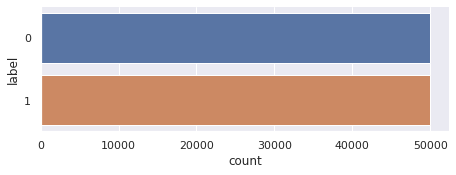

In [7]:
# class 분포 파악
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme()
sns.catplot(y='label', data = data, kind='count', height=2.6, aspect=2.5, orient='h');

In [8]:
data['label']==1

0        False
1        False
2         True
3         True
4         True
         ...  
99887    False
99888    False
99889    False
99890     True
99891     True
Name: label, Length: 99892, dtype: bool

In [9]:
liked = data[data['label']==1]
dislike = data[data['label']==0]

In [10]:
liked_review = liked[['review']].reset_index(drop=True)
dislike_review = dislike[['review']].reset_index(drop=True)
liked_review

,review
0,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
2,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
3,역시 재미있네요 전작에서 할수 없었던 자유로운 덱 빌딩도 좋네요^^
4,재미있었습니다.
...,...
49931,꿀잼보장갬
49932,3 는?
49933,찌찌 배구
49934,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.


## 2. text-mining을 위한 KoNLPy, macab 설치

In [15]:
# %%bash
# apt-get update
# apt-get install g++ openjdk-8-jdk python-dev python3-dev
# pip3 install JPype1
# pip3 install konlpy

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

In [16]:
# %env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [17]:
# %%bash
# bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
# pip3 install /tmp/mecab-python-0.996

Installing automake (A dependency for mecab-ko)
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.

In [11]:
# test
import konlpy
from konlpy.tag import Kkma, Komoran, Hannanum, Okt
from konlpy.utils import pprint
from konlpy.tag import Mecab

mecab = Mecab()
sentence = "안녕하세요 저는 천재입니다. abc"
temp_X = mecab.nouns(sentence)
temp_X

['안녕', '저', '천재']

## 3. 토큰화

In [12]:
import re
regex = r"[^a-zA-Z0-9가-힣]"
subst = ""

In [13]:
def tokenize(text):
    """text 문자열을 의미있는 단어 단위로 list에 저장합니다.
    Args:
        text (str): 토큰화 할 문자열
    Returns:
        list: 토큰이 저장된 리스트
    """
    # 정규식 적용
    tokens = re.sub(regex, subst, text)

    # 토큰화
    tokens = mecab.nouns(tokens)
    
    return tokens

In [14]:
liked_review['token'] = liked_review['review'].apply(tokenize)

In [15]:
dislike_review['token'] = dislike_review['review'].apply(tokenize)

In [16]:
liked_review

,review,token
0,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지,"[막노동, 체험, 판막, 노동, 사람, 장비, 내, 뭐]"
1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??,"[차악, 차악, 차악, 왕국, 수, 거]"
2,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요,"[시간, 과제, 시간, 수]"
3,역시 재미있네요 전작에서 할수 없었던 자유로운 덱 빌딩도 좋네요^^,"[전작, 수, 자유, 덱, 빌딩]"
4,재미있었습니다.,[]
...,...,...
49931,꿀잼보장갬,"[꿀, 잼, 보장]"
49932,3 는?,[]
49933,찌찌 배구,"[찌찌, 배구]"
49934,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.,"[야생, 사랑, 사람, 여운, 이야기, 영어]"


In [17]:
dislike_review

,review,token
0,노래가 너무 적음,[노래]
1,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다.","[황숙, 공장]"
2,베ㅈ스다 이 개^ㅐ끼들아. 시작할 때 체스판 돌아가는거 5분동안 3번 봤더나 ㅈㄴ ...,"[베스, 이, 개, 시작, 때, 체스, 판, 거, 분, 동안, 번, 무한, 로딩, ..."
3,걍 겜임 계정을 못만들어 미친겜,[]
4,관람객 vs 호랑이 불가,"[관람객, 호랑이, 불가]"
...,...,...
49951,한국어가 지원되지 않습니다. 추천하지 않습니다.,"[한국어, 지원, 추천]"
49952,엔딩도 이해가고 림보라는 제목을 정말 잘 지었어 근데 왜 도대체 이런 게임을 인디 ...,"[엔딩, 이해, 고림보, 제목, 게임, 인디, 명작]"
49953,한글화해주면 10개산다,"[한글, 개]"
49954,개쌉노잼 ㅋㅋ,[개]


## 4. 불용어 제거

In [55]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
# 욕은... 분석에 도움이 될 것 같지 않아 돌려보고 나오는 걸 입력했습니다 제가 쓴 거 아님
stop_words = "발 불편 평가 기대 환불 돈 장점 단점 건지 스팀 병신 이건 유저 망 시작 처음 쓰레기 노 자체 시발 비추 좆 플레이 거 추천 재미 한글 이게 잼 분 듯 이거 이걸 느낌 최고 건 편 패치 걸 구매 필요 가능 인데 돼 뭐 아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓 는 게임 고 다 은 도 게 면 재밌 했 음 면 음 겜 가 같이 과 까지 께 께서 께서는 들"

stop_words=stop_words.split(' ')

In [56]:
# test
liked_review['token'][0]
token = [word for word in liked_review['token'][0] if not word in stop_words]
token

['막노동', '체험', '판막', '노동', '장비']

In [57]:
result=[]
for token in liked_review['token']: 
  token = [word for word in token if not word in stop_words]
  result.append(token)

liked_review['token_2'] = result

In [58]:
result=[]
for token in dislike_review['token']: 
  token = [word for word in token if not word in stop_words]
  result.append(token)

dislike_review['token_2'] = result

In [59]:
liked_review

,review,token,token_2
0,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지,"[막노동, 체험, 판막, 노동, 사람, 장비, 내, 뭐]","[막노동, 체험, 판막, 노동, 장비]"
1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??,"[차악, 차악, 차악, 왕국, 수, 거]","[차악, 차악, 차악, 왕국]"
2,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요,"[시간, 과제, 시간, 수]",[과제]
3,역시 재미있네요 전작에서 할수 없었던 자유로운 덱 빌딩도 좋네요^^,"[전작, 수, 자유, 덱, 빌딩]","[전작, 자유, 덱, 빌딩]"
4,재미있었습니다.,[],[]
...,...,...,...
49931,꿀잼보장갬,"[꿀, 잼, 보장]","[꿀, 보장]"
49932,3 는?,[],[]
49933,찌찌 배구,"[찌찌, 배구]","[찌찌, 배구]"
49934,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.,"[야생, 사랑, 사람, 여운, 이야기, 영어]","[야생, 사랑, 여운, 이야기, 영어]"


In [60]:
from collections import Counter
liked_word_counts = Counter()
dislike_word_counts = Counter()

liked_review['token_2'].apply(lambda x: liked_word_counts.update(x))
dislike_review['token_2'].apply(lambda x: dislike_word_counts.update(x))

In [68]:
def word_count(docs):
    """ 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 리턴
    Args:
        docs (series or list): 토큰화된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')
  
word_count(liked_review['token_2']).head()

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
149,스토리,2202,2389,1.0,0.011069,0.011069,0.044096
168,친구,1465,1681,2.0,0.007789,0.018858,0.029338
83,그래픽,1505,1570,3.0,0.007275,0.026133,0.030139
101,퍼즐,1245,1473,4.0,0.006825,0.032958,0.024932
133,난이도,1101,1169,5.0,0.005417,0.038374,0.022048


In [69]:
liked_wc = word_count(liked_review['token_2'])
liked_wc_20 = liked_wc[liked_wc['rank'] <= 20]
liked_wc_20

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
149,스토리,2202,2389,1.0,0.011069,0.011069,0.044096
168,친구,1465,1681,2.0,0.007789,0.018858,0.029338
83,그래픽,1505,1570,3.0,0.007275,0.026133,0.030139
101,퍼즐,1245,1473,4.0,0.006825,0.032958,0.024932
133,난이도,1101,1169,5.0,0.005417,0.038374,0.022048
153,엔딩,959,1100,6.0,0.005097,0.043471,0.019205
140,멀티,927,1065,7.0,0.004935,0.048406,0.018564
335,시리즈,895,990,8.0,0.004587,0.052993,0.017923
274,도전,847,938,9.0,0.004346,0.057339,0.016962
94,무료,875,925,10.0,0.004286,0.061625,0.017522


In [71]:
dislike_wc = word_count(dislike_review['token_2'])
dislike_wc_20 = disliked_wc[dislike_wc['rank'] <= 20]
dislike_wc_20

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
5,버그,1918,2287,1.0,0.010581,0.010581,0.038394
117,스토리,1662,1844,2.0,0.008531,0.019112,0.033269
145,실행,1464,1715,3.0,0.007934,0.027046,0.029306
39,조작,1453,1588,4.0,0.007347,0.034393,0.029086
102,그래픽,1414,1512,5.0,0.006995,0.041388,0.028305
225,멀티,1174,1396,6.0,0.006458,0.047846,0.023501
51,서버,1138,1357,7.0,0.006278,0.054124,0.022780
90,진행,969,1062,8.0,0.004913,0.059037,0.019397
187,화면,745,845,9.0,0.003909,0.062947,0.014913
293,오류,738,838,10.0,0.003877,0.066824,0.014773


In [62]:
!pip install squarify

In [86]:
import squarify
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

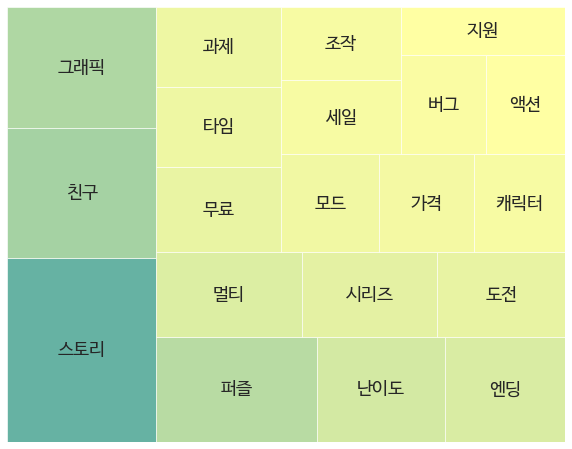

In [95]:
fig, axes = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.summer_r
mini=min(liked_wc_20['percent'])
maxi=max(liked_wc_20['percent'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in liked_wc_20['percent']]

squarify.plot(sizes=liked_wc_20['percent'], label=liked_wc_20['word'], alpha=0.6, text_kwargs={'fontsize':18}, color=colors)
plt.axis('off')
plt.show()

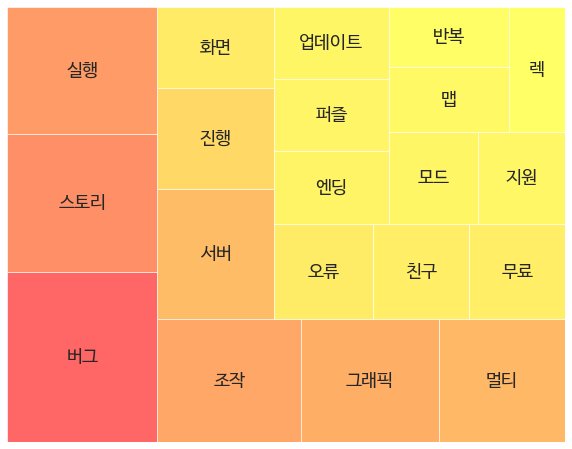

In [97]:
fig, axes = plt.subplots(figsize=(10, 8))
cmap = matplotlib.cm.autumn_r
mini=min(dislike_wc_20['percent'])
maxi=max(dislike_wc_20['percent'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in dislike_wc_20['percent']]

squarify.plot(sizes=dislike_wc_20['percent'], label=dislike_wc_20['word'], alpha=0.6, text_kwargs={'fontsize':18}, color=colors)
plt.axis('off')
plt.show()